In [1]:
import glob
import os
from bs4 import BeautifulSoup
from xml.etree.ElementTree import XML, fromstring, tostring
from xml.dom import minidom
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors as c
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Data Extraction

Data is extracted from xml files.

#### NOTE: If using csv dataframes rather than xml files, this stage of code can be skipped.

In [10]:
# I made a file with all the data I used in my model. These xml files are collected from 16 consecutive days.
os.chdir(f'{os.getcwd()}\Documents\Summer Project')
file_list = glob.glob(os.path.join(f"{os.getcwd()}\\training_files", "*.xml"))  

In [11]:
# same for files to be used for validation
test_file_list = glob.glob(os.path.join(f"{os.getcwd()}\\test_files", "*.xml"))  

In [13]:
# This cell is where I extract all the relevant information from the xml files.
all_speeds = []
all_free_flows = []
all_roads = []
times = []
jamming_factors = []
for file in file_list:
    f = open(file, "r")
    raw = f.read()
    soup = BeautifulSoup(raw, 'lxml')
    roads = soup.find_all('fi')
    for i in roads:
        attribs = []
        times.append(file[55:78])
        for child in fromstring(str(i)):
            attribs.append(child.attrib)
        if 'de' in attribs[0]:
            all_roads.append(attribs[0]['de'])
        if 'su' in attribs[-1]:
            all_speeds.append(attribs[-1]['su'])
        if 'ff' in attribs[-1]:
            all_free_flows.append(attribs[-1]['ff'])
        if 'jf' in attribs[-1]:
            jamming_factors.append(attribs[-1]['jf'])
        if 'de' not in attribs[0]:
            all_roads.append('NA')
        if 'su' not in attribs[-1]:
            all_speeds.append(0)
        if 'ff' not in attribs[-1]:
            all_free_flows.append(0)
        if 'jf' not in attribs[-1]:
            jamming_facotrs.append('NA')

In [14]:
# This cell is where I extract all the relevant information from the xml files.
all_speeds_test = []
all_free_flows_test = []
all_roads_test = []
times_test = []
for file in test_file_list:
    f = open(file, "r")
    raw = f.read()
    soup = BeautifulSoup(raw, 'lxml')
    roads = soup.find_all('fi')
    for i in roads:
        attribs = []
        times_test.append(file[51:76])
        for child in fromstring(str(i)):
            attribs.append(child.attrib)
        if 'de' in attribs[0]:
            all_roads_test.append(attribs[0]['de'])
        if 'su' in attribs[-1]:
            all_speeds_test.append(attribs[-1]['su'])
        if 'ff' in attribs[-1]:
            all_free_flows_test.append(attribs[-1]['ff'])
        if 'de' not in attribs[0]:
            all_roads_test.append('NA')
        if 'su' not in attribs[-1]:
            all_speeds_test.append(0)
        if 'ff' not in attribs[-1]:
            all_free_flows_test.append(0)

In [16]:
time_objects = []
for t in times:
    time_objects.append(datetime.strptime(f'{t[:(-4)]}', '%Y-%m-%d_%H;%M;%S'))

time_objects_test = []
for t in times_test:
    time_objects_test.append(datetime.strptime(f'{t[:(-6)]}', '%Y-%m-%d_%H;%M;%S'))

In [17]:
# Made a list which contains the weekday for each instance. This is used for when we start including the weekday information in our neural network.
weekdays = []
for d in time_objects:
    weekdays.append(d.weekday())

weekdays_test = []
for d in time_objects_test:
    weekdays_test.append(d.weekday())

In [32]:
# Created a dataframe from the scraped info. 
df = pd.DataFrame({'time':time_objects, 'weekday':weekdays,'road name':all_roads,'speeds':all_speeds,'free flow speeds':all_free_flows})
df.to_csv('training_dataframe.csv')

In [ ]:
df2 = pd.DataFrame({'time':time_objects_test, 'weekday':weekdays_test,'road name':all_roads_test,'speeds':all_speeds_test,'free flow speeds':all_free_flows_test})
df2.to_csv('testing_dataframe.csv')

# Inputs for RNNs

In [33]:
df = pd.read_csv('training_dataframe.csv')
df

,Unnamed: 0,time,weekday,road name,speeds,free flow speeds
0,0,2020-06-24 00:02:02,2,Radford,37.00,37.0
1,1,2020-06-24 00:02:02,2,Radford,37.84,38.1
2,2,2020-06-24 00:02:02,2,Bilborough,41.36,40.0
3,3,2020-06-24 00:02:02,2,Bilborough,28.00,31.6
4,4,2020-06-24 00:02:02,2,Radford,37.11,40.3
...,...,...,...,...,...,...
619771,619771,2020-07-10 00:24:01,4,Nottingham,37.32,31.7
619772,619772,2020-07-10 00:24:01,4,Wilford,48.56,54.6
619773,619773,2020-07-10 00:24:01,4,M1 Interchange J24,75.57,79.1
619774,619774,2020-07-10 00:24:01,4,Wilford,72.90,82.8


In [48]:
df2 = pd.read_csv('testing_dataframe.csv')
df2

,Unnamed: 0,time,weekday,road name,speeds,free flow speeds
0,0,2020-07-11 23:58:02,5,Radford,42.66,37.0
1,1,2020-07-11 23:58:02,5,Radford,37.02,38.1
2,2,2020-07-11 23:58:02,5,Bilborough,35.16,40.0
3,3,2020-07-11 23:58:02,5,Bilborough,25.66,31.6
4,4,2020-07-11 23:58:02,5,Radford,30.54,40.3
...,...,...,...,...,...,...
271147,271147,2020-07-19 00:02:10,6,Nottingham,28.00,31.7
271148,271148,2020-07-19 00:02:10,6,Wilford,51.90,54.6
271149,271149,2020-07-19 00:02:10,6,M1 Interchange J24,79.47,79.1
271150,271150,2020-07-19 00:02:10,6,Wilford,76.38,82.8


In [46]:
# free flow speeds are constant on each road so we only need to take the first set of free flow speeds from our extracted data.
free_flows = df['free flow speeds'][:269]

In [47]:
# Convert the information into a 269x2304 matrix (there are 269 road segments and 2304 timesteps).
speeds_roads = np.zeros([269, len(file_list)])
for road in range(269): 
    speeds_road = []
    for i in range(len(file_list)):
        speeds_road.append(df['speeds'][i*269 + road])
    speeds_roads[road] = speeds_road
speeds_roads = np.transpose(speeds_roads)

In [49]:
# Same is done for the test set.
speeds_roads_test = np.zeros([269,len(test_file_list)])
for road in range(269): 
    speeds_road_test = []
    for i in range(len(test_file_list)):
        speeds_road_test.append(df2['speeds'][i*len(roads) + road])
    speeds_roads_test[road] = speeds_road_test
speeds_roads_test = np.transpose(speeds_roads_test)

In [50]:
# This function is used to split our matrix into inpouts and outputs. The input is the historical traffic data, and the output is the future reading we are attempting to predict.
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [51]:
# Split data into sequences of inputs and outputs depending on sequence length (36 time steps or 288 were used).

#n_steps = 288
n_steps = 36

X, y = split_sequence(speeds_roads, n_steps)
print(X.shape, y.shape)

(2268, 36, 269) (2268, 269)


In [52]:
# Same is done for test set

X_test, y_test = split_sequence(speeds_roads_test, n_steps)
print(X_test.shape, y_test.shape)


(972, 36, 269) (972, 269)


In [53]:
# Training set is split further to produce a validation set used to prevent overfitting during training.

train_X = X[:1700]
train_y = y[:1700]
test_X = X[1700:]
test_y = y[1700:]

# 2 layer LSTM

In [41]:
#define model
model = tf.keras.Sequential()
model.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(269))
model.compile(loss='mse', optimizer='adam')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 36, 269)           579964    
_________________________________________________________________
lstm_3 (LSTM)                (None, 269)               579964    
_________________________________________________________________
dense_1 (Dense)              (None, 269)               72630     
Total params: 1,232,558
Trainable params: 1,232,558
Non-trainable params: 0
_________________________________________________________________
None


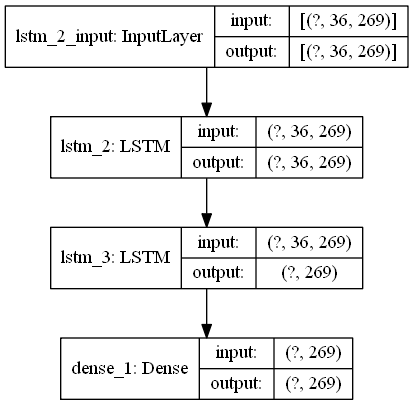

In [42]:
# model architecture
tf.keras.utils.plot_model(model, show_shapes = True)

Train on 1700 samples, validate on 568 samples
Epoch 1/50
1700/1700 [==============================] - 23s 13ms/sample - loss: 1785.9121 - val_loss: 1164.3540
Epoch 2/50
1700/1700 [==============================] - 18s 10ms/sample - loss: 921.3957 - val_loss: 608.9915
Epoch 3/50
1700/1700 [==============================] - 18s 11ms/sample - loss: 499.4559 - val_loss: 340.1226
Epoch 4/50
1700/1700 [==============================] - 18s 11ms/sample - loss: 288.3726 - val_loss: 204.3630
Epoch 5/50
1700/1700 [==============================] - 18s 10ms/sample - loss: 177.2160 - val_loss: 131.4798
Epoch 6/50
1700/1700 [==============================] - 18s 11ms/sample - loss: 115.5453 - val_loss: 91.2347
Epoch 7/50
1700/1700 [==============================] - 18s 10ms/sample - loss: 80.6470 - val_loss: 68.9703
Epoch 8/50
1700/1700 [==============================] - 18s 10ms/sample - loss: 60.8265 - val_loss: 56.7341
Epoch 9/50
1700/1700 [==============================] - 18s 11ms/sample - lo

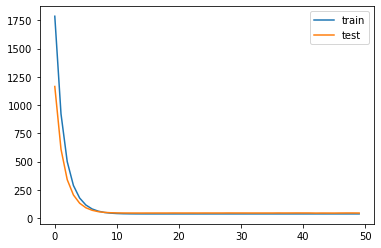

In [43]:
# Train RNN
history = model.fit(train_X, train_y, epochs = 50, validation_data=(test_X, test_y))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                  
plt.show()

In [55]:
# Calculating overall MSE for first model by making predicitons over all sequences in the test set.
mses = []
rel_mses = []
for i in range(X_test.shape[0] - 24*6):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        


        yhat = model.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses.append(rel_mse)

In [56]:
np.mean(mses)

38.84696964838412

In [57]:
np.mean(rel_mses)

0.04953362807905142

In [58]:
# Make predictions for one day to construct spatio-temporal image.

speeds = np.zeros((24*18, 269))
speeds[:n_steps] = X_test[0]
yhats = np.zeros((24*6, 269))

for t in range(0,24*6):
    x_input = speeds[t:t + n_steps]
    x_input = x_input.reshape((1,n_steps, 269))
        
    yhat = model.predict(x_input, verbose=0)
    yhats[t] = yhat
    speeds[n_steps + t] = yhat

In [ ]:
# plot spatio-temporal image of predictions.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

# 4 layer LSTM

In [ ]:
# Define model
model2 = tf.keras.Sequential()
model2.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model2.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model2.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model2.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2))
model2.add(Dense(269))
model2.compile(loss='mean_squared_error', optimizer='adam')
print(model2.summary())

In [ ]:
# Model architecture

tf.keras.utils.plot_model(model2, show_shapes = True)

In [ ]:
# Train RNN

history = model2.fit(train_X, train_y, epochs = 50, validation_data=(test_X, test_y))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                  
plt.show()

In [ ]:
# Calculating overall MSE for second model by making predicitons over all sequences in the test set.
mses2 = []
rel_mses2 = []
for i in range(X_test.shape[0] - 24*6):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        


        yhat = model2.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses2.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses2.append(rel_mse)

In [ ]:
# Make predictions for one day to construct spatio-temporal image.

speeds2 = np.zeros((24*18, 269))
speeds2[:n_steps] = X_test[0]
yhats2 = np.zeros((24*6, 269))

for t in range(0,24*6):
    x_input = speeds[t:t + n_steps]
    x_input = x_input.reshape((1,n_steps, 269))
        
    yhat = model2.predict(x_input, verbose=0)
    yhats2[t] = yhat
    speeds2[n_steps + t] = yhat

In [ ]:
# plot spatio-temporal image of predictions.

fig=plt.figure(figsize=(10, 10))
for r in range(0,269):
    for t in range(0,24*12):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats2[0][t][r]/float(free_flows[:269][r])), linewidth=3.0)
img = plt.show()

# 6 layer LSTM

In [ ]:
# define model
model3 = tf.keras.Sequential()
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model3.add(LSTM(269, input_shape=(n_steps, 269), dropout = 0.2, recurrent_dropout = 0.2))
model3.add(Dense(269))
model3.compile(loss='mean_squared_error', optimizer='adam')
print(model3.summary())

In [ ]:
# Model architecture

tf.keras.utils.plot_model(model3, show_shapes = True)

In [ ]:
# train model

history = model3.fit(train_X, train_y, epochs = 50, validation_data=(test_X, test_y))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                  
plt.show()

In [ ]:
# Calculating overall MSE for third model by making predicitons over all sequences in the test set.

mses3 = []
rel_mses3 = []
for i in range(X_test.shape[0] - 24*6):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        


        yhat = model3.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses3.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses3.append(rel_mse)

In [ ]:
# Make predictions for next 24 hours to plot spatio-temporal image.

speeds3 = np.zeros((24*18, 269))
speeds3[:n_steps] = X_test[0]
yhats3 = np.zeros((24*6, 269))

for t in range(0,24*6):
    x_input = speeds[t:t + n_steps]
    x_input = x_input.reshape((1,n_steps, 269))
        


    yhat = model3.predict(x_input, verbose=0)
    yhats3[t] = yhat
    speeds3[n_steps + t] = yhat
        

In [ ]:
# plot spatio-temporal image of predictions.

fig=plt.figure(figsize=(10, 10))
for r in range(0,269):
    for t in range(0,24*12):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats3[0][t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()